- **[MXNet How To](https://mxnet.incubator.apache.org/how_to/index.html)**
- **[MXNet System Configuration and Execution](https://mxnet.incubator.apache.org/api/python/symbol_in_pictures.html)**
- **[MXNet Symbol API](https://mxnet.incubator.apache.org/api/python/symbol.html)**

In [1]:
# Imports
import numpy as np
import mxnet as mx

**Basic Symbol Composition**

```bash
sudo apt-get install graphviz
```

In [2]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b
print a, b, c

<Symbol a> <Symbol b> <Symbol _plus0>


**NDArray operators supported by Symbol**

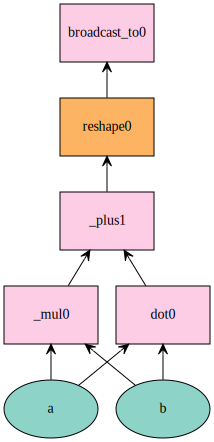

In [3]:
# Element wise multiplication
d = a * b

# Matrix multiplication
e = mx.sym.dot(a, b)

# Reshape
f = mx.sym.reshape(d + e, shape=(1, 4))

# Broadcast
g = mx.sym.broadcast_to(f, shape=(2, 4))

# Plot
mx.viz.plot_network(symbol=g)

The computations declared in the above examples can be bound to the input data for evaluation by using **bind** method.

**Basic Neural Networks**

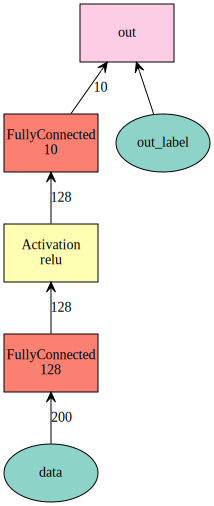

In [4]:
# Two layer fully connected network
net = mx.sym.Variable(name='data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net, shape={'data': (100, 200)})

In [5]:
# Symbol: It is like a function taking several aruments
net.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']

In [6]:
# Specifying name explicitly
net = mx.sym.Variable(name='data')
w = mx.sym.Variable('fc_w')
net = mx.sym.FullyConnected(data=net, weight=w, name='fc', num_hidden=128)
net.list_arguments()

['data', 'fc_w', 'fc_bias']

**Complicated Composition**

In [7]:
# Perform element-wise addition and feed to FC operator
lhs = mx.sym.Variable('lhs_data')
rhs = mx.sym.Variable('rhs_data')
net = mx.sym.FullyConnected(data=lhs+rhs, name='fc', num_hidden=10)
net.list_arguments()

['lhs_data', 'rhs_data', 'fc_weight', 'fc_bias']

['data', 'fc1_weight', 'fc1_bias']
['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias']


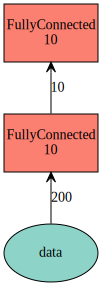

In [9]:
data = mx.sym.Variable('data')
net1 = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=10)
print net1.list_arguments()
net2 = mx.sym.Variable('data2')
net2 = mx.sym.FullyConnected(data=net2, name='fc2', num_hidden=10)
composed = net2(data2=net1, name='composed') # data2 variable
print composed.list_arguments()
mx.viz.plot_network(composed, shape={'data': (100, 200)})

**Prefix NameManager**

In [12]:
data = mx.sym.Variable('data')
net = data
n_layer = 2
for i in range(n_layer):
    with mx.name.Prefix('layer{}'.format(i+1)):
        # Prefix will add prefix "layer<i>fc
        net = mx.sym.FullyConnected(data=net, name='fc', num_hidden=100)

net.list_arguments()

['data',
 'layer1fc_weight',
 'layer1fc_bias',
 'layer2fc_weight',
 'layer2fc_bias']

**Modularized Construction for Deep Networks**
- [GoogLeNet Inception Example](https://github.com/apache/incubator-mxnet/blob/master/example/image-classification/symbols/inception-bn.py)

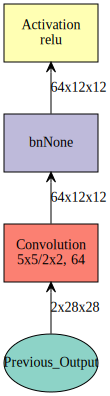

In [19]:
# Function that chains Convolution, Batch Normalization, and ReLU
def Conv_Factory(data, num_filter, kernel, stride=(1, 1), pad=(0, 0), name=None, suffix=''):
    """
    Factory function that chains Convolution, Batch Normalization, and ReLU
    """
    conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel, stride=stride, 
                              pad=pad, name='conv{}{}'.format(name, suffix))
    bn = mx.sym.BatchNorm(data=conv, name='bn{}{}'.format(name, suffix))
    relu = mx.sym.Activation(data=bn, act_type='relu', name='relu{}{}'.format(name, suffix))
    return relu

prev = mx.sym.Variable(name='Previous_Output')
conv_comp = Conv_Factory(data=prev, num_filter=64, kernel=(5, 5), stride=(2, 2),)
shape = {'Previous_Output': (128, 2, 28, 28)}
mx.viz.plot_network(symbol=conv_comp, shape=shape)

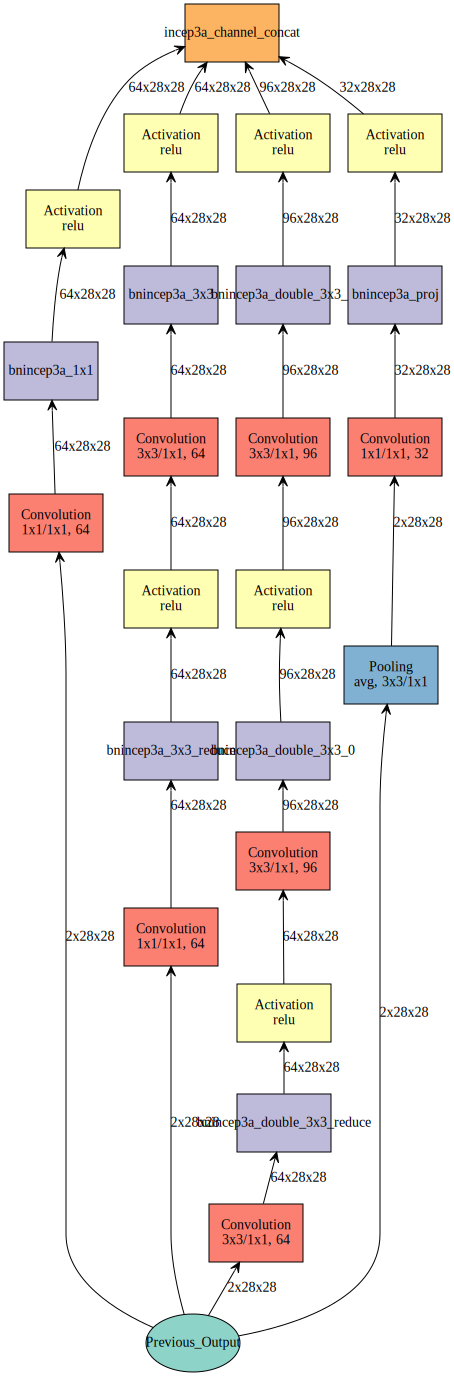

In [23]:
# Function that constructs an inception module based on convolution factory function
def Inception_Factory(data, num_1x1, num_3x3_red, num_3x3, num_d3x3_red, num_d3x3, pool, proj, name):
    # 1x1
    conv_1x1 = Conv_Factory(data=data, num_filter=num_1x1, kernel=(1, 1), name='{}_1x1'.format(name))
    # 3x3 reduce + 3x3
    conv_3x3_red = Conv_Factory(data=data, num_filter=num_3x3_red, kernel=(1, 1), name='{}_3x3'.format(name),
                                suffix='_reduce')
    conv_3x3 = Conv_Factory(data=conv_3x3_red, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), 
                            name='{}_3x3'.format(name))
    # Double 3x3 reduce + double 3x3
    conv_d3x3_red = Conv_Factory(data=data, num_filter=num_d3x3_red, kernel=(3, 3), pad=(1, 1),
                                 name='{}_double_3x3'.format(name), suffix='_reduce')
    conv_d3x3 = Conv_Factory(data=conv_d3x3_red, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), 
                             name='{}_double_3x3_0'.format(name))
    conv_d3x3 = Conv_Factory(data=conv_d3x3, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), 
                             name='{}_double_3x3_1'.format(name))
    # Pool + Proj
    pooling = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool, 
                             name='{}_pool_{}_pool'.format(pool, name))
    conv_proj = Conv_Factory(data=pooling, num_filter=proj, kernel=(1, 1), name='{}_proj'.format(name))
    # Concatenate
    concat = mx.sym.concat(*[conv_1x1, conv_3x3, conv_d3x3, conv_proj], name='{}_channel_concat'.format(name))
    return concat

prev = mx.sym.Variable(name='Previous_Output')
incep3a = Inception_Factory(prev, 64, 64, 64, 64, 96, 'avg', 32, name='incep3a')
shape = {'Previous_Output': (128, 2, 28, 28)}
mx.viz.plot_network(symbol=incep3a, shape=shape)

**Group Multiple Symbols**
- To construct neural networks with multiple loss layers use `mxnet.sym.Group` to group multiple symbols together

In [25]:
net = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=fc1, name='relu1', act_type='relu')
out1 = mx.sym.SoftmaxOutput(data=net, name='softmax')
out2 = mx.sym.LinearRegressionOutput(data=net, name='regression')
group = mx.sym.Group([out1, out2])
group.list_outputs()

['softmax_output', 'regression_output']

**NDArray**
- Imperative (computations are evaluated statement by statement)
- Straightforward
- Easy to work with native language features (for loop, if-else, etc.), numpy
- Easy step-by-step code debugging

**Symbol**
- Declarative (First declare computation and then evaluate with data, e.g. regular expression)
- Provides almost all functionalities of NDArray
- Easy to save, load and visualize
- Easy for the backend to optimize the computation and memory usage

> Important difference of Symbol compared to NDArray is that `computation is declared first and then computation is bound with data to run`

In [27]:
# Functions to manipulate symbol
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b

# Get the names of the inputs
arg_name = c.list_arguments()
print arg_name

# Get the names of the outputs
out_name = c.list_outputs()
print out_name

['a', 'b']
['_plus0_output']


In [30]:
# Infer output shape given the shape of input arguments
arg_shape, out_shape, _ = c.infer_shape(a=(2, 3), b=(2, 3))
print arg_shape, out_shape
{'input': dict(zip(arg_name, arg_shape)),
 'output': dict(zip(out_name, out_shape))}

[(2L, 3L), (2L, 3L)] [(2L, 3L)]


{'input': {'a': (2L, 3L), 'b': (2L, 3L)},
 'output': {'_plus0_output': (2L, 3L)}}

In [32]:
# Infer output type given the type of input arguments
arg_type, out_type, _ = c.infer_type(a='float32', b='float32')
print arg_type, out_type
{'input': dict(zip(arg_name, arg_type)),
 'output': dict(zip(out_name, out_type))}

[<type 'numpy.float32'>, <type 'numpy.float32'>] [<type 'numpy.float32'>]


{'input': {'a': numpy.float32, 'b': numpy.float32},
 'output': {'_plus0_output': numpy.float32}}

**Bind with Data and Evaluate**

*`bind`* method is used to feed the arguments with data to evaluate the computation declared by a constructed symbol. It accepts *device context* and a *dict* mapping free variable names to NDArrays' as arguments and returns an `executor`

In [37]:
# Bind with data
executor = c.bind(ctx=mx.cpu(), args={'a': mx.nd.ones([2, 3]),
                                      'b': mx.nd.ones([2, 3])})

# Evaluate
executor.forward()

print 'Number of outputs: ', len(executor.outputs)
print 'First output: \n', executor.outputs[0].asnumpy()

Number of outputs:  1
First output: 
[[ 2.  2.  2.]
 [ 2.  2.  2.]]


In [39]:
# Evaluate on GPU
gpu_device = mx.gpu(device_id=0)

executor_gpu = c.bind(ctx=gpu_device, args={'a': mx.nd.ones([3, 4], gpu_device)*2,
                                            'b': mx.nd.ones([3, 4], gpu_device)*3})

executor_gpu.forward()
executor_gpu.outputs[0].asnumpy()

array([[ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.]], dtype=float32)

In [40]:
# `eval` method to evaluate the symbol (combines `bind` and `forward` methods)
executor = c.eval(ctx=mx.cpu(), a=mx.nd.ones([2, 3]), b=mx.nd.ones([2, 3]))

print 'Number of outputs: ', len(executor)
print 'First output: \n', executor[0].asnumpy()

Number of outputs:  1
First output: 
[[ 2.  2.  2.]
 [ 2.  2.  2.]]


**Load and Save**
- Serialize a `Symbol` object by using *pickle* or by using *save* and *load* methods
- NDArray - Serialize the tensor data in it and directly dump to disk in binary format
- Symbol (uses concept of graph, graphs are composed by chaining operators) - Serialize the graph of which the symbol is an output. Symbol uses JSON format for serialization.

In [43]:
print c.tojson()
c.save('symbol-c.json')
c2 = mx.sym.load('symbol-c.json')
c.tojson() == c2.tojson()

{
  "nodes": [
    {
      "op": "null", 
      "name": "a", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "b", 
      "inputs": []
    }, 
    {
      "op": "elemwise_add", 
      "name": "_plus0", 
      "inputs": [[0, 0, 0], [1, 0, 0]]
    }
  ], 
  "arg_nodes": [0, 1], 
  "node_row_ptr": [0, 1, 2, 3], 
  "heads": [[2, 0, 0]], 
  "attrs": {"mxnet_version": ["int", 1100]}
}


True

**Type Cast** - To convert the data types as per requirements. MXNet uses 32-bit floats.

In [44]:
a = mx.sym.Variable('data')
b = mx.sym.cast(data=a, dtype='float16')
arg, out, _ = b.infer_type(data='float32')
print {'input': arg, 'output': out}

{'input': [<type 'numpy.float32'>], 'output': [<type 'numpy.float16'>]}


In [46]:
c = mx.sym.cast(data=a, dtype='uint8')
arg, out, _ = c.infer_type(data='int32')
print {'input': arg, 'output': out}

{'input': [<type 'numpy.int32'>], 'output': [<type 'numpy.uint8'>]}


**Variable Sharing** - To share the contents between several symbols, bind these symbols with the same array

In [48]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
b = a + a * a

data = mx.nd.ones((2, 3)) * 2
exe = b.bind(ctx=mx.cpu(), args={'a': data, 'b': data})
exe.forward()
exe.outputs[0].asnumpy()

array([[ 6.,  6.,  6.],
       [ 6.,  6.,  6.]], dtype=float32)